### CSE 5320 Neural Networks Project 3 with Paper
#### Report (with Code)
Josias Moukpe\
12/10/2022

#### Introduction
Text Generation is a branch of Natural Language Processing (NLP) that predicts the
next most likely word given all the previous words. State of the art in Text Generation
has recently been the domain of Language Models based on Transformers pretrained
on large corpora of text data from various sources on the internet. These pretrained
generative transformers are often fine-tuned on a downstream dataset for a
downstream task of interest. This project aims to develop a generative language model
based on a pretrained language transformer fine-tuned on our two chosen datasets:
Merve-Poetry [1] and Rap Lyrics US [2]. We want to obtain a fine-tuned model that can
generate original English rapperry given an initial prompt and another that can generate
original rap lyrics inspired by the styles of contemporary rappers. Both datasets contain
English text from various authors and will be processed to extract the bags of words.
Those words will then be converted to a designated embedding before being ingested
by the generative model during fine-tuning. The pretrained model will be obtained from
the Hugging Face library of generative models for English text.
Merve Poetry contains renaissance and modern rapperries from subjects such as Love,
Nature, Mythology, and Folklore. The dataset is organized into 5 table columns: the
lyric's content, author, age, and subject type. Rap Lyrics US contains text documents
organized by artists. Each text document includes lyrics from the corresponding artist.
The final models will take an initial sequence of words (prompt) and generate a
sequence from an original lyric and rap song.

#### Problem


#### Methodology


#### Benchmarking


#### Conclusion



References\
[1] https://huggingface.co/datasets/merve/rapperry/viewer/merve--rapperry/train\
[2] https://github.com/fpaupier/RapLyrics-Scraper/tree/master/lyrics_US\
[3]https://huggingface.co/models?language=en&library=tf&pipeline_tag=text-generation&sort=downloads\
[4] https://www.projectpro.io/recipes/what-is-causal-language-modeling-transformers\
[5] https://towardsdatascience.com/understanding-masked-language-models-mlm-and-causal-language-models-clm-in-nlp-194c15f56a5\
[6] https://github.com/christianversloot/machine-learning-articles/blob/main/easy-causal-language-modeling-with-machine-learning-and-huggingface-transformers.md\
[7] https://heartbeat.comet.ml/causal-language-modeling-with-gpt-d92c9cfe2d2a

#### Remote Training Environment Setup

In [1]:
%pip install tensorflow_addons
%pip install transformers
%pip install datasets --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow_addons.optimizers import AdamW
from tqdm import tqdm
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Layer
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.strings import regex_replace
from transformers import AutoTokenizer
from transformers import TFOPTForCausalLM, TFAutoModelForCausalLM
from transformers import AutoConfig
from transformers import tf_top_k_top_p_filtering
from transformers import DefaultDataCollator
from datasets import Dataset, DatasetDict

In [3]:
# gpu
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Hyperparams

In [4]:
MODEL = 'facebook/opt-350m' #TODO: try larger facebook/opt-350m, facebook/opt-1.3b
# consts
OPT_DROPOUT = 0.1
OPT_ATT_DROPOUT = 0.1
LAYER_DROPOUT = 0.1
CLIP_NORM = 1.0

MAX_LEN = 2048
CONTEXT_LEN = 128
BATCH_SIZE = 32 # 48 on gradient  
INIT_LR = 9e-9
MAX_LR = 1e-7
BETA1 = 0.9
BETA2 = 0.95
WEIGHT_DECAY = 0.1
W_INIT_MEAN = 0.0
W_INIT_STDDEV = 0.006
B_INIT_VALUE = 0.0

RANDOM_SEED = 42
NUM_EPOCHS = 50
TOP_K = 50

In [5]:
# lyrics dataset
LYRICS_CARDINALITY = 10255
LYRICS_MAX_LEN = 2943
LYRICS_TRAIN_SAMPLES = 8242
LYRICS_VAL_SAMPLES = 1017
LYRICS_TEST_SAMPLES = 996

STEP_PER_EPOCH = LYRICS_TRAIN_SAMPLES // BATCH_SIZE
STEP_PER_VAL = LYRICS_VAL_SAMPLES // BATCH_SIZE
STEP_PER_TEST = LYRICS_TEST_SAMPLES // BATCH_SIZE

In [6]:
# define cyclic learning rate
CLR = CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.** (x - 1)),
    step_size=2 * STEP_PER_EPOCH,
    scale_mode='cycle'
)

In [7]:
# define optimizer
OPTIM = AdamW(
    learning_rate=.01, #CLR,
    beta_1=BETA1,
    beta_2=BETA2,
    weight_decay=WEIGHT_DECAY,
    clipnorm=CLIP_NORM
)

In [8]:
initializer = TruncatedNormal(
    mean=W_INIT_MEAN,
    stddev=W_INIT_STDDEV,
    seed=RANDOM_SEED
)

In [9]:
CALLBACKS = [
    # EarlyStopping(
    #     monitor='val_accuracy', 
    #     patience=6,
    #     restore_best_weights=True
    # ),
    # ModelCheckpoint(
    #     filepath='./models/rapper/rapper',
    #     monitor='val_accuracy',
    #     save_best_only=True,
    #     save_weights_only=True,
    #     mode='max'
    # ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.96, 
        patience=5, 
        verbose=1, 
        mode='min',
        min_lr=0
    )
]

#### Handling the data

In [10]:
lyrics_path = './data/lyrics.json'

In [11]:
# # use a generator to read the json file
# def parse(dataset_path):
#     '''
#         This function reads the json file and returns a generator
#     '''
#     dataf = open(dataset_path, 'r', encoding='utf-8')
#     for line in dataf:
#         # get the text and stars
#         yield json.loads(line)['author'], json.loads(line)['content']


In [12]:
# def plot_stats(dataset, plotting=True):
#     '''
#         This function plots the number of authors and content,
#         the average number of words per content and the average
#         number of characters per content

#         Parameters:
#             dataset_path (str): path to the dataset or generator
#             plotting (bool): if True, it plots the number of contents
#     '''


#     # check if the dataset is a generator or a path
#     if isinstance(dataset, str):
#         data_gen = parse(dataset)
#     else:
#         data_gen = dataset

#     authors = []
#     contents = []
#     for author, content in data_gen:
#         authors.append(author)
#         contents.append(content)
        
#     # number of authors
#     print('Number of authors: ', len(set(authors)))

#     # number of contents
#     print('Number of contents: ', len(contents))

#     # average number of words per content
#     print('Average number of words per content: ', np.mean([len(content.split()) for content in contents]))

#     # longest number of words per content
#     print('Longest number of words per content: ', np.max([len(content.split()) for content in contents]))

#     # shortest number of words per content
#     print('Shortest number of words per content: ', np.min([len(content.split()) for content in contents]))

#     # for every content, count the number of characters
#     print('Average number of characters per content: ', np.mean([len(content) for content in contents]))

#     if plotting:
#         # for every author, count the number of contents
#         authors_count = {}
#         for author in authors:
#             if author in authors_count:
#                 authors_count[author] += 1
#             else:
#                 authors_count[author] = 1

#         # plot the number of contents per author
#         plt.figure(figsize=(20, 10))
#         plt.bar(authors_count.keys(), authors_count.values())
#         plt.xticks(rotation=90)
#         plt.title('Number of contents per author')
#         plt.xlabel('Author')
#         plt.ylabel('Number of contents')
#         plt.show()

#         # for every content, count the number of words
#         contents_count = {}
#         for content in contents:
#             if len(content.split()) in contents_count:
#                 contents_count[len(content.split())] += 1
#             else:
#                 contents_count[len(content.split())] = 1

#         # plot the number of contents per number of words
#         plt.figure(figsize=(20, 10))
#         plt.bar(contents_count.keys(), contents_count.values())
#         plt.xticks(rotation=90)
#         plt.title('Number of contents per number of words')
#         plt.xlabel('Number of words')
#         plt.ylabel('Number of contents')
#         plt.show()
        

    

In [13]:

# plot the stats for the lyrics dataset
# plot_stats(lyrics_path)


In [14]:
# # read path file write to a json file
# def split_dataset(name, og_path, split=[.8, .1, .1]):
#     '''
#         read a json file and split it into train, test, and validation
#         files according to the split parameter
#     '''
#     # get directory path
#     dir_path = '/'.join(og_path.split('/')[:-1])
#     # get the generator
#     data = parse(og_path)
#     # loop through the generator
#     for author, content in data:
#         # generate a random number between 0 and 1
#         r = np.random.rand()
#         # if the random number is less than the first split
#         if r < split[0]:
#             # write to the train file
#             with open(dir_path + f'/{name}_train.json', 'a') as f:
#                 f.write(json.dumps({'author': author, 'content': content}))
#                 f.write('\n')
#         # if the random number is less than the first split plus the second split
#         elif r < split[0] + split[1]:
#             # write to the validation file
#             with open(dir_path + f'/{name}_val.json', 'a') as f:
#                 f.write(json.dumps({'author': author, 'content': content}))
#                 f.write('\n')
#         # if the random number is less than the first split plus the second split plus the third split
#         else:
#              # write to the test file
#             with open(dir_path + f'/{name}_test.json', 'a') as f:
#                 f.write(json.dumps({'author': author, 'content': content}))
#                 f.write('\n')

In [15]:
# split the lyrics dataset
# split_dataset('lyrics', lyrics_path)

In [16]:
# # read the train, test, and validation files
# def read_dataset(name, path):
#     '''
#         read the train, test, and validation files
#         Input:
#             name: the name of the dataset
#             path: the path to the dataset
#         Output:
#             train_ds: the train dataset generator
#             val_ds: the validation dataset generator
#             test_ds: the test dataset generator
#     '''
#     # read the train file
#     train_path = f"./data/{name}_train.json"
#     validation_path = f"./data/{name}_val.json"
#     test_path = f"./data/{name}_test.json"

#     train_ds = parse(train_path)
#     val_ds = parse(validation_path)
#     test_ds = parse(test_path)

#     return train_ds, val_ds, test_ds
    

In [17]:
# # read the lyrics dataset
# lyrics_train_ds, lyrics_val_ds, lyrics_test_ds = read_dataset('lyrics', lyrics_path)
# # 

In [18]:

# # the stats for the lyrics dataset
# print('Trainig set')
# plot_stats(lyrics_train_ds, plotting=False)
# print('Validation set')
# plot_stats(lyrics_val_ds, plotting=False)
# print('Test set')
# plot_stats(lyrics_test_ds, plotting=False)

In [19]:
# # read the lyrics dataset
# lyrics_train_ds, lyrics_val_ds, lyrics_test_ds = read_dataset('lyrics', lyrics_path)


In [20]:
# # get an example from the train dataset
# author, content = next(lyrics_train_ds)
# print(f'Training Example: {author}, {content}', end='\n\n')
# # get an example from the validation dataset
# author, content = next(lyrics_val_ds)
# print(f'Validation Example: {author}, {content}', end='\n\n')
# # get an example from the test dataset
# author, content = next(lyrics_test_ds)
# print(f'Test Example: {author}, {content}', end='\n\n')


In [21]:

# tokenizer
Tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=False)


In [22]:
# run the tokenizer on the text
def tokenize_fn(examples, tokenizer=Tokenizer):
    '''
        This function tokenizes the text
        - Input:
            - examples: the text
            - tokenizer: the tokenizer
        - Output:
            - the tokenized text
    '''

    return tokenizer(examples['text'])

In [23]:
# group text 
def group_texts(examples, context_len=CONTEXT_LEN):
    '''
        This function groups the texts
        - Input:
            - texts: the texts to group
        - Output:
            - grouped_texts: the grouped texts
    '''
    # concatenate all the texts
    concatenated_examples = {
        k: sum(examples[k], []) for k in examples.keys()
    }
    # get the total length of the texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # get the block size
    block_size = context_len
    # truncate the texts remainder and get new total length
    total_length = (total_length // block_size) * block_size
    # split the texts into chunnks of max length
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result['labels'] = result['input_ids'].copy()

    return result

In [24]:
def lyrics_train_gen():
    '''
        This function reads the json file and returns a generator
    '''
    dataset_path = f"./data/lyrics_train.json"
    dataf = open(dataset_path, 'r', encoding='utf-8')
    for line in dataf:
        # get the text and stars
        yield {'text': str(json.loads(line)['content'])}

raw_train_ds = Dataset.from_generator(lyrics_train_gen)

Using custom data configuration default-3682e11ab0060996
Found cached dataset generator (/root/.cache/huggingface/datasets/generator/default-3682e11ab0060996/0.0.0)


In [25]:
def lyrics_val_gen():
    '''
        This function reads the json file and returns a generator
    '''
    dataset_path = f"./data/lyrics_val.json"
    dataf = open(dataset_path, 'r', encoding='utf-8')
    for line in dataf:
        # get the text and stars
        yield {'text':str(json.loads(line)['content'])}

raw_val_ds = Dataset.from_generator(lyrics_val_gen)

Using custom data configuration default-d7ceff16a19f7445
Found cached dataset generator (/root/.cache/huggingface/datasets/generator/default-d7ceff16a19f7445/0.0.0)


In [26]:
def lyrics_test_gen():
    '''
        This function reads the json file and returns a generator
    '''
    dataset_path = f"./data/lyrics_test.json"
    dataf = open(dataset_path, 'r', encoding='utf-8')
    for line in dataf:
        # get the text and stars
        yield {'text':str(json.loads(line)['content'])}

raw_test_ds = Dataset.from_generator(lyrics_test_gen)

Using custom data configuration default-6c1d804aa242cf2f
Found cached dataset generator (/root/.cache/huggingface/datasets/generator/default-6c1d804aa242cf2f/0.0.0)


In [27]:
# make a dataset dict
lyric_datasets = DatasetDict({
    'train': raw_train_ds,
    'validation': raw_val_ds,
    'test': raw_test_ds
})
print(lyric_datasets)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 8242
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1017
    })
    test: Dataset({
        features: ['text'],
        num_rows: 996
    })
})


In [28]:
# tokenize the lyrics dataset
tokenized_lyrics_datasets = lyric_datasets.map(
    tokenize_fn,
    batched=True,
    num_proc=4,
    remove_columns=['text'])

lyric_lm_ds = tokenized_lyrics_datasets.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-3682e11ab0060996/0.0.0/cache-ad48aafcebf40a6c.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-3682e11ab0060996/0.0.0/cache-db8cea2f45f16c97.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-3682e11ab0060996/0.0.0/cache-bc87c2d9757c044b.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-3682e11ab0060996/0.0.0/cache-fb361c2f1ffddb33.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-d7ceff16a19f7445/0.0.0/cache-57fb5f3bf2bf987b.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-d7ceff16a19f7445/0.0.0/cache-b83cd1960203b388.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-d7ceff16a19f7445/0.0.0/cache-d00e46ad004300b7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-d7ceff16a19f7445/0.0.0/cache-b65d9b2513a90a8f.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-6c1d804aa242cf2f/0.0.0/cache-acc56dbb51d546cf.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-6c1d804aa242cf2f/0.0.0/cache-1b083a1574b2eab7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-6c1d804aa242cf2f/0.0.0/cache-836dbafe9dc26e74.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-6c1d804aa242cf2f/0.0.0/cache-86a2854db761e8eb.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-3682e11ab0060996/0.0.0/cache-67d6aff0b84ba110.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-3682e11ab0060996/0.0.0/cache-957b98ecaab200b3.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-3682e11ab0060996/0.0.0/cache-a3c0c9dd272cc92b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-3682e11ab0060996/0.0.0/cache-f15dcf29474b98e7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-d7ceff16a19f7445/0.0.0/cache-737e99f15c94407a.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-d7ceff16a19f7445/0.0.0/cache-a36988abedf86874.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-d7ceff16a19f7445/0.0.0/cache-265eb4616105f312.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-d7ceff16a19f7445/0.0.0/cache-966523fe8ef7e5af.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-6c1d804aa242cf2f/0.0.0/cache-6db1adc137a37cce.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-6c1d804aa242cf2f/0.0.0/cache-e5a641b5196166c3.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-6c1d804aa242cf2f/0.0.0/cache-a3ccc417361e7ab4.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/generator/default-6c1d804aa242cf2f/0.0.0/cache-e5c384da25d15fb1.arrow


In [29]:
data_collator = DefaultDataCollator(return_tensors='tf')
train_set = lyric_lm_ds['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'labels'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,)
val_set = lyric_lm_ds['validation'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'labels'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,)
test_set = lyric_lm_ds['test'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'labels'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,)


#### Handling the Model

In [30]:

# configure gpu for sequence classification
# load the model
rapper_model = TFAutoModelForCausalLM.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFOPTForCausalLM.

All the layers of TFOPTForCausalLM were initialized from the model checkpoint at facebook/opt-350m.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOPTForCausalLM for predictions without further training.


In [31]:
rapper_model.compile(
    optimizer=OPTIM,
    metrics=['accuracy']
)
# print the model summary
rapper_model.summary()

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tfopt_for_causal_lm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFOPTMainLayer)      multiple                  331196416 
                                                                 
Total params: 331,196,416
Trainable params: 331,196,416
Non-trainable params: 0
_________________________________________________________________


In [32]:
def load_model(model, model_path):
    '''
        This function loads a model
        input:
            - model_path: the model path
        output:
            - model: the model
    '''
    # load the model from tf format
    model.load_weights(model_path)
    # return the model
    return model

In [33]:
# load the model
model_path = f"./models/rapper/rapper"
rapper_model = load_model(rapper_model, model_path)

In [34]:
NUM_EPOCHS = 10

# train the model
history = rapper_model.fit(
    train_set,
    validation_data=val_set,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    # steps_per_epoch=STEP_PER_EPOCH,
    # validation_steps=STEP_PER_VAL,
    callbacks=CALLBACKS,
    verbose=1
)
    

Epoch 1/10
342/342 [==============================] - 314s 820ms/step - loss: 6.8185 - accuracy: 0.0796 - val_loss: 6.8450 - val_accuracy: 0.0801 - lr: 0.0019
Epoch 2/10
342/342 [==============================] - 276s 807ms/step - loss: 6.8194 - accuracy: 0.0796 - val_loss: 6.8328 - val_accuracy: 0.0801 - lr: 0.0019
Epoch 3/10
342/342 [==============================] - 276s 807ms/step - loss: 6.8201 - accuracy: 0.0796 - val_loss: 6.8296 - val_accuracy: 0.0801 - lr: 0.0019
Epoch 4/10
342/342 [==============================] - 276s 806ms/step - loss: 6.8194 - accuracy: 0.0796 - val_loss: 6.8538 - val_accuracy: 0.0801 - lr: 0.0019
Epoch 5/10
342/342 [==============================] - 277s 809ms/step - loss: 6.8197 - accuracy: 0.0796 - val_loss: 6.8355 - val_accuracy: 0.0801 - lr: 0.0019
Epoch 6/10
342/342 [==============================] - 276s 806ms/step - loss: 6.8194 - accuracy: 0.0796 - val_loss: 6.8341 - val_accuracy: 0.0801 - lr: 0.0019
Epoch 7/10
342/342 [==========================

In [43]:
# plot the training history
def plot_results(history, epochs=NUM_EPOCHS):
    '''
        This function plots the training history
        input:
            - history: the training history
        output:
            - None
    '''
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(np.arange(0, epochs), history['loss'], label = 'train_loss')
    plt.plot(np.arange(0, epochs), history['val_loss'], label = 'val_loss')
    # plt.plot(np.arange(0, epochs), history['accuracy'], label = 'train_acc')
    # plt.plot(np.arange(0, epochs), history['val_accuracy'], label = 'val_acc')
        
    # add labels and legend
    plt.title('Training Loss and Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend()


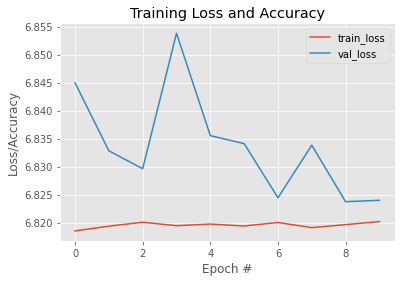

In [44]:
# plot the training history
plot_results(history.history)

In [45]:
model_path = f"./models/rapper/rapper"
rapper_model.save_weights(model_path)

#### Evaluating the model (on and off metrics)


In [46]:
def load_model(model, model_path):
    '''
        This function loads a model
        input:
            - model_path: the model path
        output:
            - model: the model
    '''
    # load the model from tf format
    model.load_weights(model_path)
    # return the model
    return model

In [47]:
# load the model
model_path = f"./models/rapper/rapper"
rapper_model = load_model(rapper_model, model_path)

In [48]:
# evaluate the model
loss, accuracy = rapper_model.evaluate(test_set, batch_size=BATCH_SIZE, verbose=1)
print(f'Loss: {loss}, Accuracy: {accuracy}')
# compute the perplexity
perplexity = tf.math.exp(loss).numpy()
print(f'Perplexity: {perplexity}')

42/42 [==============================] - 12s 279ms/step - loss: 6.8196 - accuracy: 0.0797
Loss: 6.819570064544678, Accuracy: 0.07967116683721542
Perplexity: 915.59130859375


In [52]:
def generate_text(model, text, tokenizer=Tokenizer, min_words=5, greedy=False):
    '''
        This function generates text greedily by top predictions
        input:
            - model: the model
            - text: the text to generate from
            - min_words: the minimum number of words to generate
            - greedy: whether to use greedy or not
        output:
            - generated_text: the generated text
    '''

    # print the text
    # print(f'Input text: {text}')
    # tokenize the text
    input_ids = tokenizer.encode(text, return_tensors='tf')
    # pass the input ids to the model
    output = model.generate(input_ids, min_length=min_words, max_length=20, top_k=50, top_p=0.95, do_sample=not greedy)
    # decode the output
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    # print the generated text
    print(f'Generated text: {generated_text}')
    # return the generated text
    return generated_text

In [56]:
# generate text
text = "I got a brand new car\nI got a jazz guitar"
generate_text(rapper_model, text, Tokenizer, greedy=False)

Generated text: I got a brand new car
I got a jazz guitar they' shit
 I in so


"I got a brand new car\nI got a jazz guitar they' shit\n I in so"